In [1]:
from pandas import DataFrame, read_csv
from matplotlib.pyplot import figure, title, savefig, show
from seaborn import heatmap
import libs.ds_charts as ds
from imblearn.over_sampling import SMOTE

ISTO E APLICADO ANTES DO TRAIN/ TEST SPLIT -> porque o test tem de ter as mesmas features do train!

In [2]:
filename = 'data/air_quality_dummified.csv'
data = read_csv(filename, na_values='?')
data.shape

(161631, 60)

In [3]:
THRESHOLD = 0.9

def select_redundant(corr_mtx, threshold: float) -> tuple[dict, DataFrame]:
    if corr_mtx.empty:
        return {}

    corr_mtx = abs(corr_mtx)
    vars_2drop = {}
    for el in corr_mtx.columns:
        el_corr = (corr_mtx[el]).loc[corr_mtx[el] >= threshold]
        if len(el_corr) == 1:
            corr_mtx.drop(labels=el, axis=1, inplace=True)
            corr_mtx.drop(labels=el, axis=0, inplace=True)
        else:
            vars_2drop[el] = el_corr.index
    return vars_2drop, corr_mtx

drop1, corr_mtx1 = select_redundant(data.corr(), 0.9)
print(len(drop1))
drop2, corr_mtx2 = select_redundant(data.corr(), 0.7)
print(len(drop2))

drop3, corr_mtx3 = select_redundant(data.corr(), 0.5)


8
24


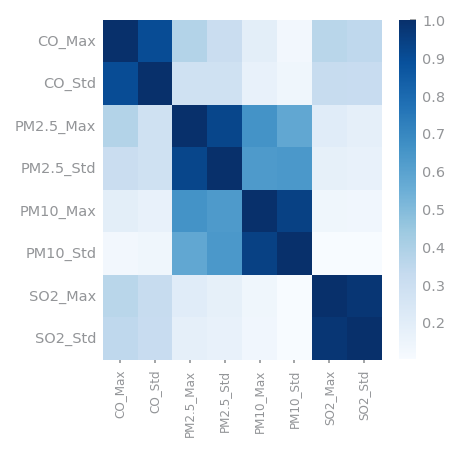

In [4]:
if corr_mtx1.empty:
    raise ValueError('Matrix is empty.')

figure(figsize=[3, 3])
heatmap(corr_mtx1, xticklabels=corr_mtx1.columns, yticklabels=corr_mtx1.columns, annot=False, cmap='Blues')
#title('Filtered Correlation Analysis')
#savefig(f'lab6_images/filtered_correlation_analysis_d1_{THRESHOLD}.png')
show()

In [5]:
def drop_redundant(data: DataFrame, vars_2drop: dict) -> DataFrame:
    sel_2drop = []
    print(vars_2drop.keys())
    for key in vars_2drop.keys():
        if key not in sel_2drop:
            for r in vars_2drop[key]:
                if r != key and r not in sel_2drop:
                    sel_2drop.append(r)
    print('Variables to drop', sel_2drop)
    df = data.copy()
    for var in sel_2drop:
        df.drop(labels=var, axis=1, inplace=True)
    return df

df1 = drop_redundant(data, drop1)
df2 = drop_redundant(data, drop2)
df3 = drop_redundant(data, drop3)

dict_keys(['CO_Max', 'CO_Std', 'PM2.5_Max', 'PM2.5_Std', 'PM10_Max', 'PM10_Std', 'SO2_Max', 'SO2_Std'])
Variables to drop ['CO_Std', 'PM2.5_Std', 'PM10_Std', 'SO2_Std']
dict_keys(['CO_Mean', 'CO_Min', 'CO_Max', 'CO_Std', 'NO2_Mean', 'NO2_Min', 'NO2_Max', 'NO2_Std', 'O3_Mean', 'O3_Min', 'O3_Max', 'O3_Std', 'PM2.5_Mean', 'PM2.5_Min', 'PM2.5_Max', 'PM2.5_Std', 'PM10_Mean', 'PM10_Min', 'PM10_Max', 'PM10_Std', 'SO2_Mean', 'SO2_Min', 'SO2_Max', 'SO2_Std'])
Variables to drop ['CO_Min', 'CO_Max', 'NO2_Min', 'NO2_Max', 'O3_Min', 'O3_Max', 'PM2.5_Min', 'PM2.5_Max', 'PM10_Mean', 'PM10_Min', 'PM10_Std', 'SO2_Min', 'SO2_Max', 'SO2_Std']
dict_keys(['CO_Mean', 'CO_Min', 'CO_Max', 'CO_Std', 'NO2_Mean', 'NO2_Min', 'NO2_Max', 'NO2_Std', 'O3_Mean', 'O3_Min', 'O3_Max', 'O3_Std', 'PM2.5_Mean', 'PM2.5_Min', 'PM2.5_Max', 'PM2.5_Std', 'PM10_Mean', 'PM10_Min', 'PM10_Max', 'PM10_Std', 'SO2_Mean', 'SO2_Min', 'SO2_Max', 'SO2_Std'])
Variables to drop ['CO_Min', 'CO_Max', 'CO_Std', 'NO2_Mean', 'NO2_Min', 'PM2.5_Mea

In [6]:
df2.shape

(161631, 46)

8 ['Prov_EN_Guangdong', 'Prov_EN_Jiangsu', 'Prov_EN_Shandong', 'Prov_EN_Sichuan', 'date_1', 'date_2', 'date_3', 'date_4']


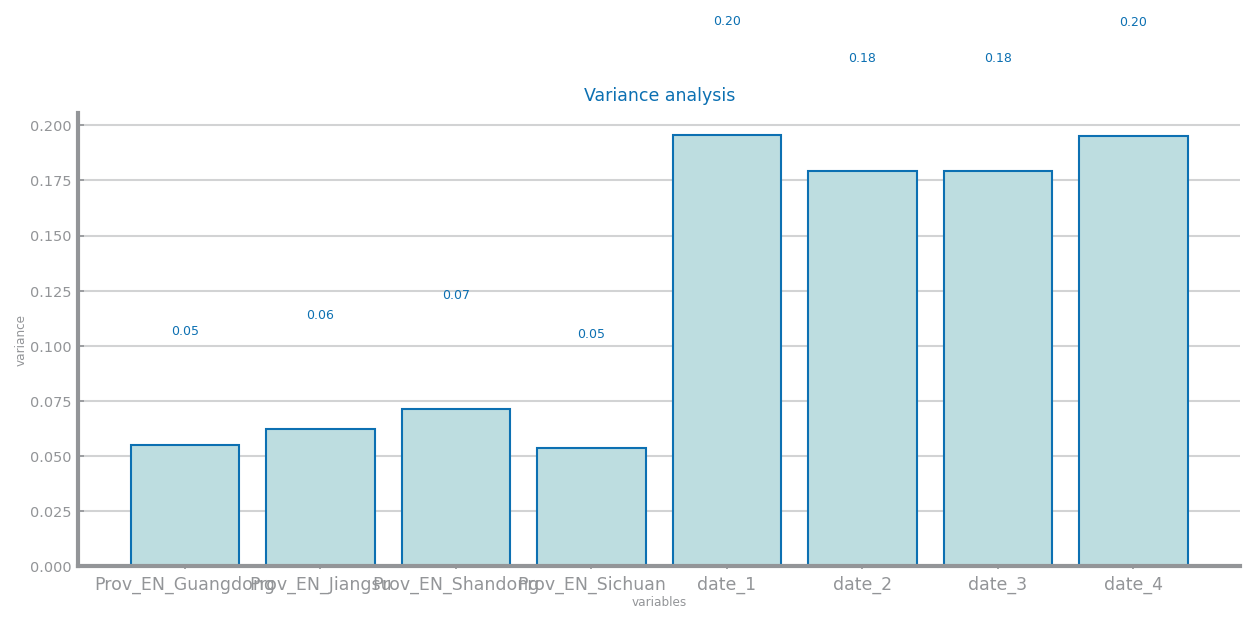

In [7]:

from matplotlib.pyplot import figure, savefig, show
from libs.ds_charts import bar_chart, get_variable_types
def select_low_variance(data: DataFrame, threshold: float) -> list:
    lst_variables = []
    lst_variances = []
    for el in data.columns:
        value = data[el].astype(int).var()
        if value >= threshold:
            lst_variables.append(el)
            lst_variances.append(value)

    print(len(lst_variables), lst_variables)
    figure(figsize=[10, 4])
    bar_chart(lst_variables, lst_variances, title='Variance analysis', xlabel='variables', ylabel='variance')
    savefig('lab6_images/filtered_variance_analysis_ds1.png')
    return lst_variables

numeric = get_variable_types(data)['Binary']
numeric.remove('ALARM')
vars_2drop = select_low_variance(data[numeric], 0.05)

for var in vars_2drop:
    if var in list(df1.columns):
        df1.drop(var,inplace=True,axis=1)
    if var in list(df2.columns):
        df2.drop(var,inplace=True,axis=1)
    if var in list(df3.columns):
        df3.drop(var,inplace=True,axis=1)

In [8]:
data.shape
df2.shape

(161631, 38)

### Train Test Split with feature selection

In [9]:
import numpy as np
from pandas import read_csv, concat, unique, DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def split(df):
    target = 'ALARM'
    positive = 'Danger'
    negative = 'Safe'
    values = {'Original': [len(df[df[target] == positive]), len(df[df[target] == negative])]}

    y: np.ndarray = df.pop(target).values
    X: np.ndarray = df.values
    labels: np.ndarray = unique(y)
    labels.sort()

    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    return concat([DataFrame(trnX, columns=df.columns), DataFrame(trnY,columns=[target])], axis=1) , concat([DataFrame(tstX, columns=df.columns), DataFrame(tstY,columns=[target])], axis=1)


### Naive Bayes Impact


In [10]:
import model_tests as mt
trn0,tst0 = split(data.copy())
trn1,tst1 = split(df1.copy())
trn2,tst2 = split(df2.copy())
trn3,tst3 = split(df3.copy())

In [11]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
import numpy as np
from pandas import DataFrame, read_csv, unique
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def nb(train_new,test_new):
    target = 'ALARM'
    trnY_new: np.ndarray = train_new.pop(target).values
    trnX_new: np.ndarray = train_new.values
    labels = unique(trnY_new)
    labels.sort()

    tstY_new: np.ndarray = test_new.pop(target).values
    tstX_new: np.ndarray = test_new.values

    clf = BernoulliNB()
    clf.fit(trnX_new, trnY_new)
    prd_trn = clf.predict(trnX_new)
    prd_tst = clf.predict(tstX_new)
    return [f1_score(tstY_new, prd_tst, pos_label='Danger'), recall_score(tstY_new, prd_tst, pos_label='Danger'), precision_score(tstY_new, prd_tst, pos_label='Danger'), accuracy_score(tstY_new, prd_tst)]



In [12]:
def balancing(dataset):
    target = 'ALARM'
    target_count = dataset[target].value_counts()
    positive_class = target_count.idxmin()
    negative_class = target_count.idxmax()

    df_positives = dataset[dataset['ALARM'] == "Danger"]
    df_negatives = dataset[dataset['ALARM'] == "Safe"]
    values = {'Original': [target_count[positive_class], target_count[negative_class]]}

    RANDOM_STATE = 42
    # SMOTE + UNDERSAMPLE
    smote2 = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)

    df_neg_sample = DataFrame(df_negatives.sample(60000))
    df_under = concat([df_positives, df_neg_sample], axis=0)

    y = df_under.pop(target).values
    X = df_under.values
    smote_X, smote_y = smote2.fit_resample(X, y)
    columns_for_new = dataset.columns.drop('ALARM')
    df_smote_under = concat([DataFrame(smote_X, columns=columns_for_new), DataFrame(smote_y, columns=[target])], axis=1)
    #df_smote_under.to_csv(f'data/report/balanced/air_quality_smoteunder.csv', index=False)
    return df_smote_under

In [13]:



a = nb(trn0.copy(),tst0.copy())
b = nb(trn1.copy(),tst1.copy())
c = nb(trn2.copy(),tst2.copy())
d = nb(trn3.copy(),tst3.copy())


0.28195287830944865
0.2913178898189605
0.2950400629209065
0.31333170850597125
0.5701375245579567
0.5880157170923379
0.5895874263261297
0.631434184675835


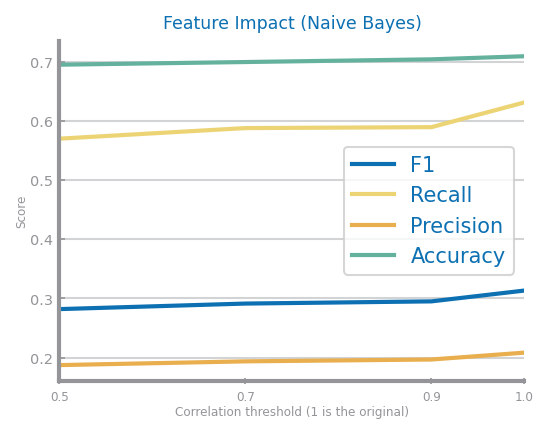

In [14]:
print(b[0])
print(c[0])
print(d[0])
print(a[0])

print(b[1])
print(c[1])
print(d[1])
print(a[1])
ds.multiple_line_chart([0.5,0.7,0.9,1],{"F1":[b[0],c[0],d[0],a[0]],"Recall":[b[1],c[1],d[1],a[1]],"Precision":[b[2],c[2],d[2],a[2]],"Accuracy":[b[3],c[3],d[3],a[3]]},title="Feature Impact (Naive Bayes)",xlabel="Correlation threshold (1 is the original)",ylabel="Score")

### KNN Impact

In [15]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
import numpy as np
from pandas import DataFrame, read_csv, unique
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier

def knn(train_new,test_new):
    target = 'ALARM'
    trnY_new: np.ndarray = train_new.pop(target).values
    trnX_new: np.ndarray = train_new.values
    labels = unique(trnY_new)
    labels.sort()

    tstY_new: np.ndarray = test_new.pop(target).values
    tstX_new: np.ndarray = test_new.values

    clf = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    clf.fit(trnX_new, trnY_new)
    prd_trn = clf.predict(trnX_new)
    prd_tst = clf.predict(tstX_new)
    return [f1_score(tstY_new, prd_tst, pos_label='Danger'), recall_score(tstY_new, prd_tst, pos_label='Danger'), precision_score(tstY_new, prd_tst, pos_label='Danger'), accuracy_score(tstY_new, prd_tst)]



In [16]:
a1 = knn(trn0.copy(),tst0.copy())
print(a1)
b1 = knn(trn1.copy(),tst1.copy())
print(b1)
c1 = knn(trn2.copy(),tst2.copy())
print(c1)
d1 = knn(trn3.copy(),tst3.copy())
print(d1)
ds.multiple_line_chart([0.5,0.7,0.9,1],{"F1":[b1[0],c1[0],d1[0],a1[0]],"Recall":[b1[1],c1[1],d1[1],a1[1]],"Precision":[b1[2],c1[2],d1[2],a1[2]],"Accuracy":[b1[3],c1[3],d1[3],a1[3]]},title="Feature Impact (KNN)",xlabel="Correlation threshold (1 is the original)",ylabel="Score")

### Random Forests Impact

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def rf(train_new,test_new): 
    target = 'ALARM'
    trnY_new: np.ndarray = train_new.pop(target).values
    trnX_new: np.ndarray = train_new.values
    labels = unique(trnY_new)
    labels.sort()

    tstY_new: np.ndarray = test_new.pop(target).values
    tstX_new: np.ndarray = test_new.values

    clf = RandomForestClassifier(n_estimators=125,max_depth=5,max_features=0.9)
    clf.fit(trnX_new, trnY_new)
    prd_trn = clf.predict(trnX_new)
    prd_tst = clf.predict(tstX_new)
    return [f1_score(tstY_new, prd_tst, pos_label='Danger'), recall_score(tstY_new, prd_tst, pos_label='Danger'), precision_score(tstY_new, prd_tst, pos_label='Danger'), accuracy_score(tstY_new, prd_tst)]



In [ ]:
a2 = rf(trn0.copy(),tst0.copy())
print(a2)
b2 = rf(trn1.copy(),tst1.copy())
print(b2)
c2 = rf(trn2.copy(),tst2.copy())
print(c2)
d2 = rf(trn3.copy(),tst3.copy())
print(d2)
ds.multiple_line_chart([0.5,0.7,0.9,1],{"F1":[b2[0],c2[0],d2[0],a2[0]],"Recall":[b2[1],c2[1],d2[1],a2[1]],"Precision":[b2[2],c2[2],d2[2],a2[2]],"Accuracy":[b2[3],c2[3],d2[3],a2[3]]},title="Feature Impact (RF)",xlabel="Correlation threshold (1 is the original)",ylabel="Score")